In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
from collections import Counter
from datetime import timedelta, datetime

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

from keras.layers import Dense, Dropout
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from xgboost import XGBClassifier

# 0. read data 

- `data/train.csv` - 10506 rows × 12 columns with `WnvPresent` and `NumMosquitos`
    1. Date: date that the WNV test is performed
    2. Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
    3. Species: the species of mosquitos
    4. Block: block number of address
    5. Street: street name
    6. Trap: Id of the trap
    7. AddressNumberAndStreet: approximate address returned from GeoCoder
    8. Latitude
    9. Longitude
    10. AddressAccuracy: accuracy returned from GeoCoder
    11. **NumMosquitos**: number of mosquitoes caught in this trap
    12. **WnvPresent**: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 
- `data/test.csv` - 116293 rows × 10 columns 
- `data/spray.csv` - 14835 rows × 4 columns
    - `Date`, `Time`, `Latitude`, `Longitude`
- `data/weather.csv` - 2944 rows × 22 columns
    - `Station`, `Date`, `Tmax`, `Tmin`, `Tavg`, `Depart`, `DewPoint`, `WetBulb`, `Heat`, `Cool`, `Sunrise`, `Sunset`, `CodeSum`, `Depth`, `Water1`, `SnowFall`, `PrecipTotal`, `StnPressure`, `SeaLevel`, `ResultSpeed`, `ResultDir`, `AvgSpeed`

In [97]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
spray = pd.read_csv('data/spray.csv')
weather = pd.read_csv('data/weather.csv')

In [98]:
def get_month(date, divide_3=False):
    year, month, day = date.year, date.month, date.day
    year_month = str(year) + '_' + str(month).zfill(2)
    if divide_3:
        if day < 10:
            return year_month + ' early'
        elif day < 20:
            return year_month + ' mid'
        else:
            return year_month + ' late'
    else:
        return year_month

## Create new columns : year, month, year_month
train['Date'] = pd.to_datetime(train.Date)
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Year_Month'] = train.Date.apply(get_month)  ## 2013, 8 -> 2013_08
train['Year_Month3'] = train.Date.apply(lambda x: get_month(x, divide_3=True))  ## month + (early, mid, late)

test['Date'] = pd.to_datetime(test.Date)
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Year_Month'] = test.Date.apply(get_month)  ## 2013, 8 -> 2013_08

## mapped target label to string
train['WnvPresent_num'] = train['WnvPresent']  ## original column - 0 or 1
train['WnvPresent'] = train['WnvPresent'].map({0:'not present', 1:'present'})  ## mapped string

# 1. EDA

## 1.1. numerical features :

- `WnvPresent` (bool) - target variable
- `NumMosquitos` (int) - not exist in test data 
- `Year`
- `Month`
- `Latitude`
- `Longitude`
- `AddressAccuracy` (int)

#### all correlations

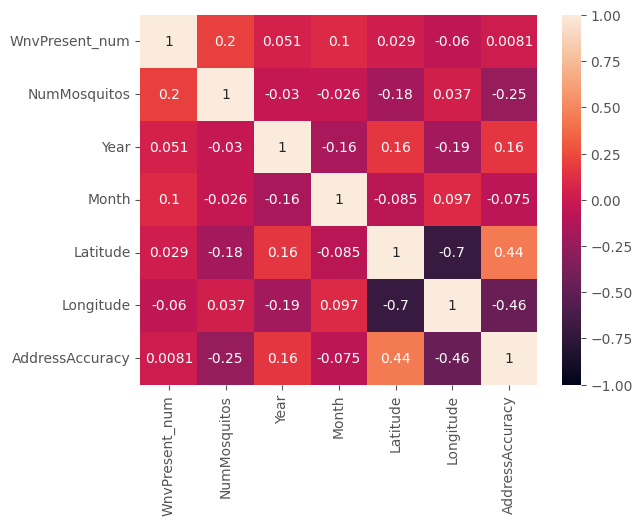

In [99]:
num_cols = ['WnvPresent_num','NumMosquitos','Year','Month','Latitude','Longitude','AddressAccuracy']
sns.heatmap(train[num_cols].corr(), annot=True, vmin=-1, vmax=1);

#### `year` in train vs test

- no matching year

In [100]:
print('----- TRAIN -----')
print(train['Year'].value_counts())
print('\n----- TEST -----')
print(test['Year'].value_counts())

----- TRAIN -----
Year
2007    3811
2013    2392
2009    2249
2011    2054
Name: count, dtype: int64

----- TEST -----
Year
2010    36557
2008    30498
2012    27115
2014    22123
Name: count, dtype: int64


#### WNV by time

- most frequently observed every August

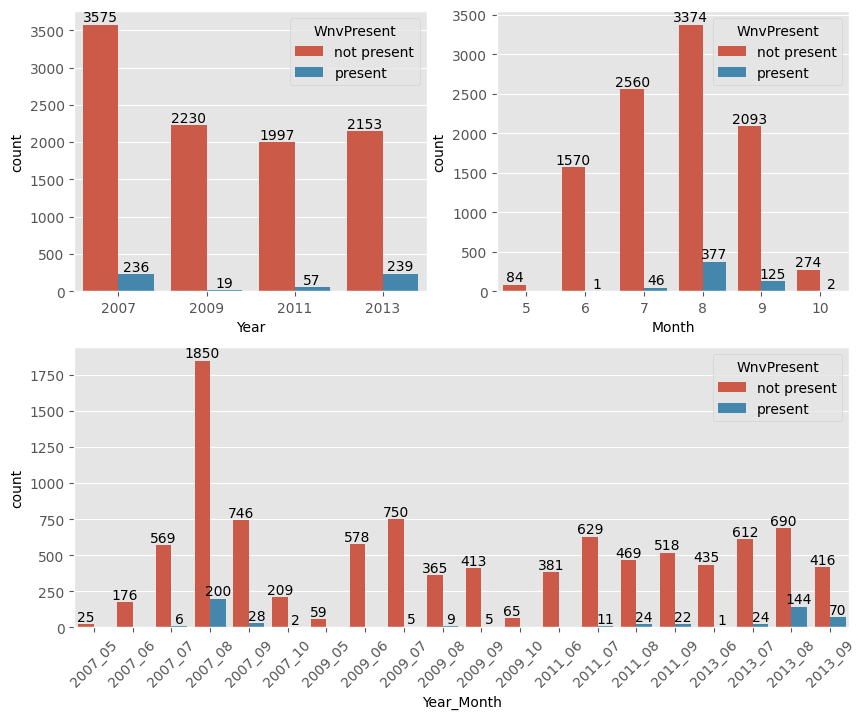

In [101]:
## visualization by datetime
fig, axes = plt.subplot_mosaic("AB;CC", figsize=(10, 8))

## WNV by year
ax = sns.countplot(x='Year', hue='WnvPresent', data=train, ax=axes['A'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

## WNV by month
ax = sns.countplot(x='Month', hue='WnvPresent', data=train, ax=axes['B'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

## WNV by year-month 
ax = sns.countplot(x='Year_Month', hue='WnvPresent', data=train, ax=axes['C'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45);

### plot `Latitude` and `Longitude` to map

- WNV is widely observed in Chicago
- plot size is `NumMosquitos` 

In [102]:
## plot one month
fig = px.scatter_mapbox(
    data_frame=train[(train.Year_Month == "2013_08")],
    title="year = 2013_08",
    lat="Latitude", lon="Longitude",
    size="NumMosquitos",
    color='WnvPresent',
    zoom=9.5,
    height=800, width=800,
    mapbox_style='open-street-map')
fig.show()

In [103]:
## plot only Present by year_month
fig = px.scatter_mapbox(
    data_frame=train[train.WnvPresent_num==1],
    lat="Latitude", lon="Longitude",
    color='WnvPresent',
    size="NumMosquitos",
    animation_frame='Year_Month',
    mapbox_style='carto-positron',           
    zoom=9.5,
    height=800, width=800)
fig.show();


## 1.2. categorical features

- `Species` - 7 unique values
- `Block`
- `Street` - 128 unique values
- `Address` -138 unique values
- `Trap` - 136 unique values 

#### `Species`

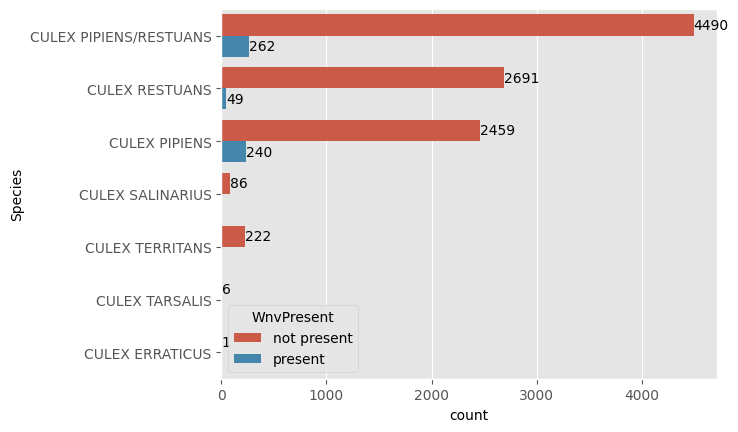

In [104]:
ax = sns.countplot(y='Species', hue='WnvPresent', data=train)
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1]);

#### `Block`, `Street`, `Address`

- `Block` + `Street` = `Address` (both has 138 unique values)
- to use only `Address` is enough

In [105]:
## Block + Street
print('Block + Street :', (train['Block'].astype(str) + train['Street']).nunique())

## Address
print('Address :', train['Address'].nunique())

## show values
pd.concat([train['Block'].astype(str) + train['Street'], train['Address']], axis=1).drop_duplicates()

Block + Street : 138
Address : 138


0                                            Address
0      41 N OAK PARK AVE  4100 North Oak Park Avenue, Chicago, IL 60634,...
2       62 N MANDELL AVE  6200 North Mandell Avenue, Chicago, IL 60646, USA
3        79 W FOSTER AVE    7900 West Foster Avenue, Chicago, IL 60656, USA
5       15 W WEBSTER AVE   1500 West Webster Avenue, Chicago, IL 60614, USA
6         25 W GRAND AVE     2500 West Grand Avenue, Chicago, IL 60654, USA
...                  ...                                                ...
7466  62 N MCCLELLAN AVE  6200 North Mcclellan Avenue, Chicago, IL 60646...
7635        29 W 85TH ST      2900 West 85th Street, Chicago, IL 60652, USA
7821        34 W 77TH ST      3400 West 77th Street, Chicago, IL 60652, USA
8667    96 S LONGWOOD DR  9600 South Longwood Drive, Chicago, IL 60643, USA
9552      21 N CANNON DR    2100 North Cannon Drive, Chicago, IL 60614, USA

[138 rows x 2 columns]

#### `Trap`

In [106]:
train['Trap'].value_counts()

Trap
T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: count, Length: 136, dtype: int64

## 1.3. spray data

- 4 columns
    - `Date`
    - `Time`
    - `Latitude`
    - `Longitude`
- only 2011 (2 days) and 2013 (8 days)

In [107]:
## Create new columns : year, month, year_month
spray['Date'] = pd.to_datetime(spray.Date)
spray['Year'] = spray.Date.dt.year
spray['Month'] = spray.Date.dt.month
spray['Year_Month'] = spray.Date.apply(get_month)  ## 2013, 8 -> 2013_08
spray

Date        Time   Latitude  Longitude  Year  Month Year_Month
0     2011-08-29  6:56:58 PM  42.391623 -88.089163  2011      8    2011_08
1     2011-08-29  6:57:08 PM  42.391348 -88.089163  2011      8    2011_08
2     2011-08-29  6:57:18 PM  42.391022 -88.089157  2011      8    2011_08
3     2011-08-29  6:57:28 PM  42.390637 -88.089158  2011      8    2011_08
4     2011-08-29  6:57:38 PM  42.390410 -88.088858  2011      8    2011_08
...          ...         ...        ...        ...   ...    ...        ...
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355  2013      9    2013_09
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015  2013      9    2013_09
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392  2013      9    2013_09
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423  2013      9    2013_09
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460  2013      9    2013_09

[14835 rows x 7 columns]

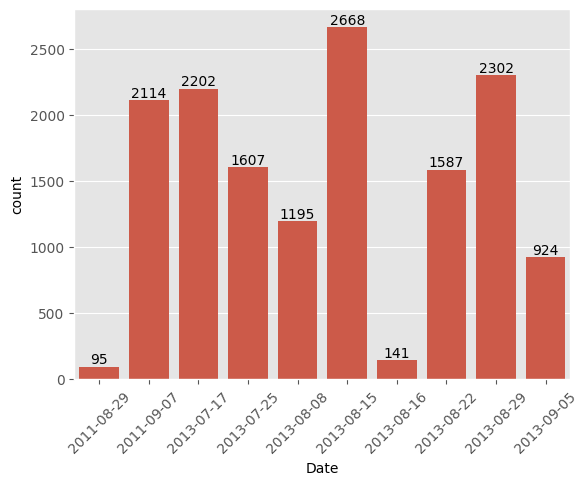

In [108]:
## spray times
ax = sns.countplot(data=spray, x='Date')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45);

In [109]:
fig = px.scatter_mapbox(
    data_frame=spray,
    lat="Latitude", lon="Longitude",
    zoom=10,
    color='Date',
    height=800, width=800,
    mapbox_style='open-street-map')
fig.show()

#### Does spraying help reducing mosquitos?

- 2011-09-07
- 2013-07-17
- 2013-07-25
- 2013-08-08
- 2013-08-15
- 2013-08-16
- 2013-08-22
- 2013-08-29
- 2013-09-05

In [110]:
def present_after_spray(year, month, day, durations=[0, 7, 14, 21, 28]):
    spray_date = datetime(year, month, day)
    date_filter = (spray.Date==spray_date)

    ## get the location of corners of the sprayed block
    long_min = spray.loc[date_filter, 'Longitude'].min()
    long_max = spray.loc[date_filter, 'Longitude'].max()
    lat_min = spray.loc[date_filter, 'Latitude'].min()
    lat_max = spray.loc[date_filter, 'Latitude'].max()

    ## train data within duration
    result_df = pd.DataFrame(index=['not present', 'present'])
    for i in range(len(durations) - 1):
        duration_start, duration_end = durations[i], durations[i+1]
        date_condition = (train.Date > spray_date + timedelta(days=duration_start)) & (train.Date <= spray_date + timedelta(days=duration_end))
        long_condition = (train.Longitude >= long_min) & (train.Longitude <= long_max)
        lat_condition = (train.Latitude >= lat_min) & (train.Latitude <= lat_max)
        filtered = train[date_condition & long_condition & lat_condition]
        
        result_df[f'{duration_start}-{duration_end} days'] = len(filtered[filtered.WnvPresent_num==0]), len(filtered[filtered.WnvPresent_num==1])
    result_df.loc['SUM'] = result_df.sum()
    result_df['SUM in 4 weeks'] = result_df.sum(axis=1)

    print(f'--- after spray @ {str(spray_date).split()[0]} ---')
    display(result_df); print()
    return result_df

In [111]:
spray_dates = [(2011,9,7), (2013,7,17), (2013,7,25), (2013,8,8), (2013,8,15), (2013,8,16), (2013,8,22), (2013,8,29), (2013,9,5)]
for y, m, d in spray_dates:
    present_after_spray(y, m ,d)

--- after spray @ 2011-09-07 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         2          2           1           2               7
present             0          0           1           0               1
SUM                 2          2           2           2               8


--- after spray @ 2013-07-17 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present       107         97         110          95             409
present            11          1          11          27              50
SUM               118         98         121         122             459


--- after spray @ 2013-07-25 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         4          2           3           2              11
present             0          0           0           1               1
SUM                 4          2           3           3              12


--- after spray @ 2013-08-08 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         1          1           2           0               4
present             0          0           0           0               0
SUM                 1          1           2           0               4


--- after spray @ 2013-08-15 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         9         10           0          18              37
present             3          3           0           5              11
SUM                12         13           0          23              48


--- after spray @ 2013-08-16 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         4          5           3           4              16
present             1          1           2           1               5
SUM                 5          6           5           5              21


--- after spray @ 2013-08-22 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present        33          0          74          29             136
present             4          0           7           2              13
SUM                37          0          81          31             149


--- after spray @ 2013-08-29 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         0         65          26          21             112
present             0         17           2           0              19
SUM                 0         82          28          21             131


--- after spray @ 2013-09-05 ---


0-7 days  7-14 days  14-21 days  21-28 days  SUM in 4 weeks
not present         2          1           1           0               4
present             2          0           0           0               2
SUM                 4          1           1           0               6

#### combine spray table and original table to plot in map

In [112]:
spray2 = spray[['Date','Latitude','Longitude','Year_Month']].copy()
spray2['Point'] = 'spray'
spray2['NumMosquitos'] = 1  ## set minimum value to plot as small dot 

train2 = train[['Date','Latitude','Longitude','Year_Month','NumMosquitos','WnvPresent']].rename(columns={'WnvPresent':'Point'})
spray2 = pd.concat([spray2, train2])

In [113]:
fig = px.scatter_mapbox(
    data_frame=spray2,
    lat="Latitude", lon="Longitude",
    zoom=9,
    hover_name='Date',
    animation_frame='Year_Month',
    size='NumMosquitos',
    color='Point', 
    height=800, width=800)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

## 1.4. weather data

- `Station`, `Date`, `Tmax`, `Tmin`, `Tavg`, `Depart`, `DewPoint`, `WetBulb`, `Heat`, `Cool`, `Sunrise`, `Sunset`, `CodeSum`, `Depth`, `Water1`, `SnowFall`, `PrecipTotal`, `StnPressure`, `SeaLevel`, `ResultSpeed`, `ResultDir`, `AvgSpeed`
- 2 stations - `1`: ASOS, `2`: AWOS (1472 records, respectively)
- station==2 has many missing values `'M'`


In [114]:
## convert datatype into datetime
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month
weather['Year_Month'] = weather.Date.apply(get_month)  ## 2013, 8 -> 2013_08

## data only station 1
weather1 = weather[weather.Station == 1].copy()

## convert datatype
weather1['AvgSpeed'] = weather1['AvgSpeed'].astype(float)

#### `Tmax` and `Tmin`

- almost no difference between station 1 and station 2 -> use only station 1

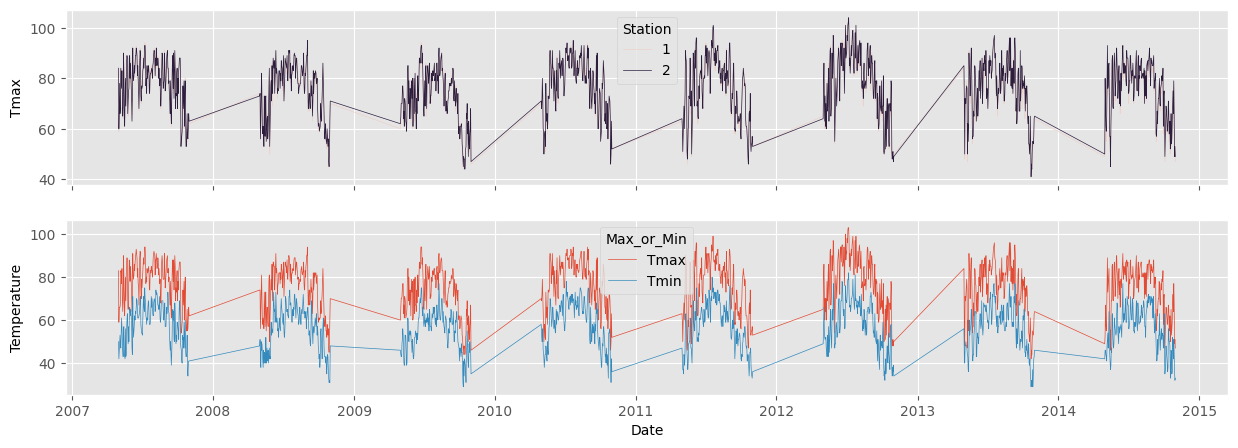

In [115]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,5))

## Tmax : station 1 vs station 2
sns.lineplot(x='Date', y='Tmax', hue='Station', data=weather, lw=0.5, ax=axes[0]);

## Tmax vs Tmin @ Station 1
sns.lineplot(x='Date', y='Temperature', hue='Max_or_Min', data=weather1[['Date','Tmax', 'Tmin']].melt('Date', var_name='Max_or_Min', value_name='Temperature'), lw=0.5, ax=axes[1]);

### what are `Heat` and `Cool`?

- they strongly correlate with temperature - may not help

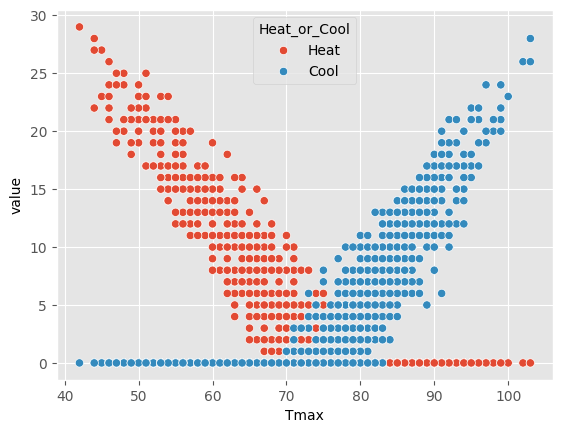

In [116]:
## cast datatype as int (original: string)
weather1['Heat'] = weather1.Heat.astype(int)
weather1['Cool'] = weather1.Cool.astype(int)

## scatter Tmax vs Heat/Cool
sns.scatterplot(x='Tmax', y='value', hue='Heat_or_Cool',  data=weather1[['Tmax', 'Heat', 'Cool']].melt('Tmax', var_name='Heat_or_Cool'));

In [117]:
## drop columns
weather1.drop(columns=['Heat','Cool'], inplace=True)

### `CodeSum`

- abbreviation of weather 
    - e.g. `RA`: rain, `BR`: mist, `HZ`: haze
- one day can have multiple values: `RA` & `SN`

In [118]:
## list of string
weather_list = weather1.CodeSum.apply(lambda x: x.strip().split(' ')) 

## make unique list 
weather_count = Counter()
weather_count.update(sum(weather_list, []))
print('num of weather :', len(weather_count.keys()))

## sort values
weather_count.most_common()

num of weather : 15


[('', 805),
 ('RA', 475),
 ('BR', 411),
 ('TSRA', 150),
 ('HZ', 105),
 ('DZ', 58),
 ('TS', 53),
 ('FG+', 16),
 ('FG', 11),
 ('VCTS', 8),
 ('FU', 5),
 ('BCFG', 3),
 ('MIFG', 3),
 ('SQ', 1),
 ('SN', 1)]

#### create new colums:
- `is_rain` - RA
- `is_mist` - BR
- `is_haze` - HZ

In [119]:
weather1['is_rain'] = weather_list.apply(lambda x: 'RA' in x).astype(int)
weather1['is_mist'] = weather_list.apply(lambda x: 'BR' in x).astype(int)
weather1['is_haze'] = weather_list.apply(lambda x: 'HZ' in x).astype(int)

#### `is_rain` vs `Tmax`/`Tmin`

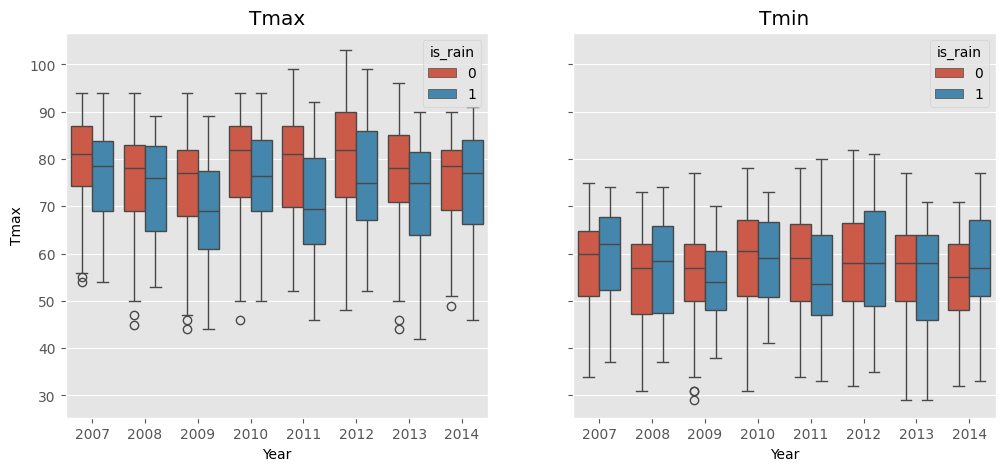

In [120]:
## boxplot 
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.boxplot(x='Year', hue='is_rain', y='Tmax', data=weather1, ax=axes[0]); axes[0].set_title('Tmax');
sns.boxplot(x='Year', hue='is_rain', y='Tmin', data=weather1, ax=axes[1]); axes[1].set_title('Tmin');

## 1.5. join tables

In [121]:
merged_df = train.merge(right=weather1, on=['Date','Year','Month','Year_Month'], how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  object        
 12  Year                    10506 non-null  int32 

#### does `AvgSpeed` correlate with `WnvPresent`?

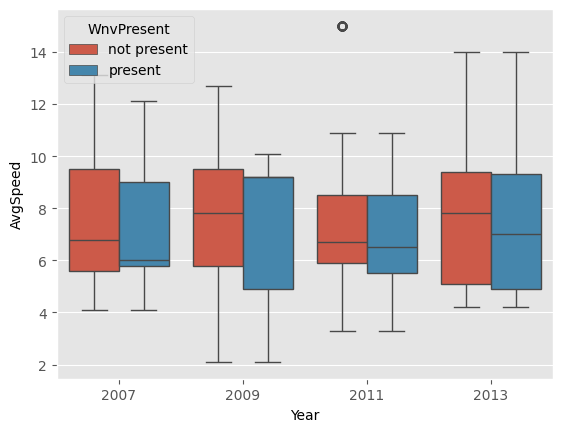

In [122]:
sns.boxplot(x='Year', hue='WnvPresent', y='AvgSpeed', data=merged_df);

#### does `Tmax` correlate with `WnvPresent`?

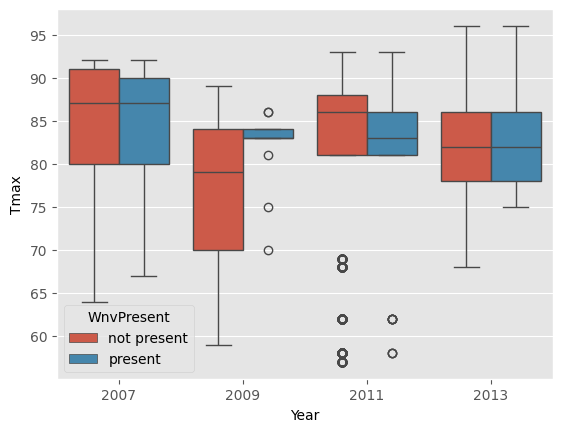

In [123]:
sns.boxplot(x='Year', hue='WnvPresent', y='Tmax', data=merged_df);

#### does `is_rain` correlate with `WnvPresent`?

In [124]:
merged_df.groupby(['Year', 'is_rain'])['WnvPresent'].value_counts(normalize=True).unstack(level=0) * 100

Year                      2007       2009       2011       2013
is_rain WnvPresent                                             
0       not present  95.629300  98.975860  97.096594  89.636689
        present       4.370700   1.024140   2.903406  10.363311
1       not present  90.447761  99.433107  98.098859  90.883590
        present       9.552239   0.566893   1.901141   9.116410

#### does `is_rain` correlate with `NumMosquitos`?

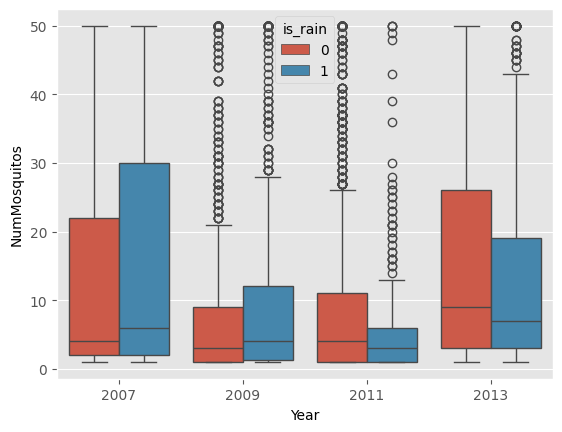

In [125]:
sns.boxplot(x='Year', hue='is_rain', y='NumMosquitos', data=merged_df);

#### create "past" features

- `Tmax_pastN` - mean of `Tmax` in past N days
- `Rain_pastN` - sum of `is_rain` in past N Days  

In [126]:
def get_past_temp(date, past_days=3, temp='Tmax'):
    weather_filter = (weather1.Date < date) & (weather1.Date >= date - timedelta(days=past_days))
    return weather1[weather_filter][temp].mean()

def get_past_rain(date, past_days=3):
    weather_filter = (weather1.Date < date) & (weather1.Date >= date - timedelta(days=past_days))
    return weather1[weather_filter]['is_rain'].sum()

merged_df['Tmax_past3'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmax'))
merged_df['Tmax_past7'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmax'))
merged_df['Tmin_past3'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmin'))
merged_df['Tmin_past7'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmin'))
merged_df['Rain_past3'] = merged_df['Date'].apply(lambda x: get_past_rain(x, 3))

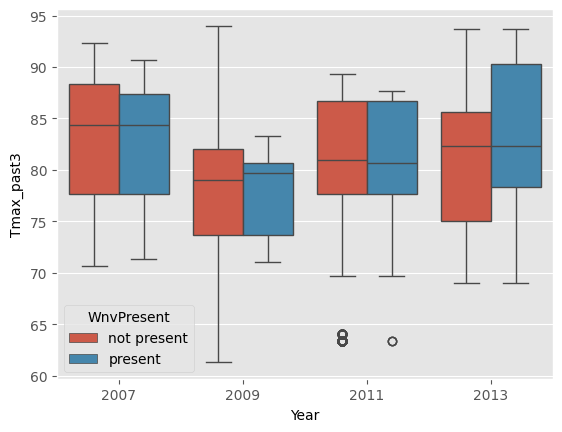

In [127]:
sns.boxplot(y='Tmax_past3', x='Year', hue='WnvPresent', data=merged_df);

## 1.6. recent WNV present

> use approximate distance

- mean of lat, long : (41.94, -87.72)
- 111.11km / 1 degree for latitude
- 111.11*cos(41.94) = 82.64km / 1 degree for longitude

> create new binary features:

- `present_within3km_in7days`
- `present_within5km_in7days`
- `present_within3km_in14days`
- `present_within5km_in14days`

In [128]:
present_df = train[train.WnvPresent_num==1].reset_index(drop=True).copy()
present_df.rename(columns={'NumMosquitos':'recent_NumMosquitos'}, inplace=True)

def get_distance(row, latitude, longitude):
    lat_diff = abs(row['Latitude'] - latitude)
    long_diff = abs(row['Longitude'] - longitude)
    return ((lat_diff * 111.11)**2 + (long_diff * 82.64)**2)**0.5 + 0.1 ## 100m offset

def get_recent_present(row, past_days=20, lat_width=0.1, long_width=0.1):
    date, latitude, longitude = row['Date'], row['Latitude'], row['Longitude']
    date_condition = (present_df.Date < date) & (present_df.Date >= date - timedelta(days=past_days))
    lat_condition = (present_df.Latitude - latitude).abs() < lat_width 
    long_condition = (present_df.Longitude - longitude).abs() < long_width
    filtered_df = present_df[date_condition & lat_condition & long_condition].copy()
    
    ## calculate distance to each point
    filtered_df['recent_distance'] = filtered_df.apply(lambda row: get_distance(row, latitude, longitude), axis=1)
    filtered_df['recent_daybefore'] = filtered_df['Date'].apply(lambda x: (date-x).days)
    
    ## get features
    if len(filtered_df) == 0:
        return pd.Series({
        'present_within3km_in7days' : 0,
        'present_within5km_in7days' : 0,
        'present_within3km_in14days' : 0,
        'present_within5km_in14days' : 0})
    else:
        filter_distance3km, filter_distance5km = filtered_df.recent_distance <= 3, filtered_df.recent_distance <= 5
        filter_daybefore7, filter_daybefore14 = filtered_df.recent_daybefore <= 7, filtered_df.recent_daybefore <= 14
        return pd.Series({
        'present_within3km_in7days' : len(filtered_df[filter_distance3km & filter_daybefore7].groupby(['Date','Address']).count()),
        'present_within5km_in7days' : len(filtered_df[filter_distance5km & filter_daybefore7].groupby(['Date','Address']).count()),
        'present_within3km_in14days' : len(filtered_df[filter_distance3km & filter_daybefore14].groupby(['Date','Address']).count()),
        'present_within5km_in14days' : len(filtered_df[filter_distance5km & filter_daybefore14].groupby(['Date','Address']).count()),})
    
## example
s = train.loc[10005]
get_recent_present(s)

present_within3km_in7days     1
present_within5km_in7days     6
present_within3km_in14days    1
present_within5km_in14days    7
dtype: int64

In [129]:
merged_df = pd.concat([merged_df, merged_df.apply(get_recent_present, axis=1)], axis=1)
merged_df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   ...  is_haze Tmax_past3  Tmax_past7  Tmin_past3 Tmin_past7 Rain_past3  \
0  ...        1       73.0        79.0        52.0  55.714286          3   
1  ...        1       73.0        79.0        52.0  55.714286          3   
2  ...        1       73.0        79.0        52.0  55.714286          3   
3  ...        1       73.0        79.0        52.0  55.714286          3   
4  ...        1       73.0        79.0        52.0  55.714286          3   

   present_within3km_in7days  present_within5km_in7days  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   present_within3km_in14days  present_within5km_in14days  
0                           0                           0  
1                           0                           0  
2                           0                           0  
3                           0                           0  
4                           0                           0  

[5 rows x 48 columns]

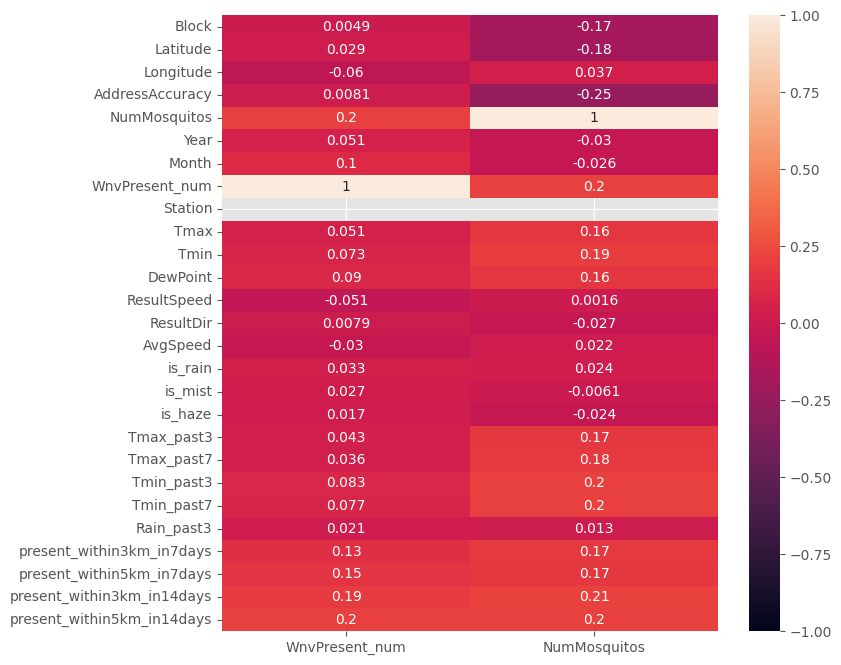

In [130]:
## Correlations
plt.figure(figsize=(8,8))
sns.heatmap(merged_df.corr(numeric_only=True)[['WnvPresent_num','NumMosquitos']], annot=True, vmin=-1, vmax=1);

# 2. Modelling

In [131]:
feature_num = [
    'Year',
    'Tmax', 'Tmax_past7', 'Tmin', 'Tmin_past3',  'Tmin_past7',
    'is_rain', 'is_mist', 'Rain_past3', 'DewPoint'
    ]
feature_cat = ['Month', 'Species', 'Address']

## X and y
## polynomial features & dummify categorical features
poly = PolynomialFeatures(degree=2)
X = pd.concat([
    pd.DataFrame(poly.fit_transform(merged_df[feature_num]), columns=poly.get_feature_names_out(), index=merged_df.index),
    pd.get_dummies(merged_df[feature_cat], drop_first=True, dtype=int)], axis=1)
y = merged_df['WnvPresent_num']

## scaling
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

## train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8404, 210) (8404,)
(2102, 210) (2102,)


In [132]:
def evaluate(model):
    pred_test = model.predict(X_test)
    probs_train = model.predict_proba(X_train)[:,1]
    probs_test = model.predict_proba(X_test)[:,1]
    auc_train = round(roc_auc_score(y_train, probs_train), 4)
    auc_test = round(roc_auc_score(y_test, probs_test), 4)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)

    ## plot
    plt.figure(figsize=(12, 5))
    
    ## confusion matrix
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test)).plot(ax=ax)
    plt.grid(False); plt.title('Confusion Matrix for test')

    ## ROC curve
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=auc_train).plot(ax=ax, name='train')
    RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=auc_test).plot(ax=ax, name='test')
    plt.plot((0,1), (0,1)); plt.title(f'ROC curve (AUC: {auc_test})')
    plt.show()

### 2.1. Logistic Regression

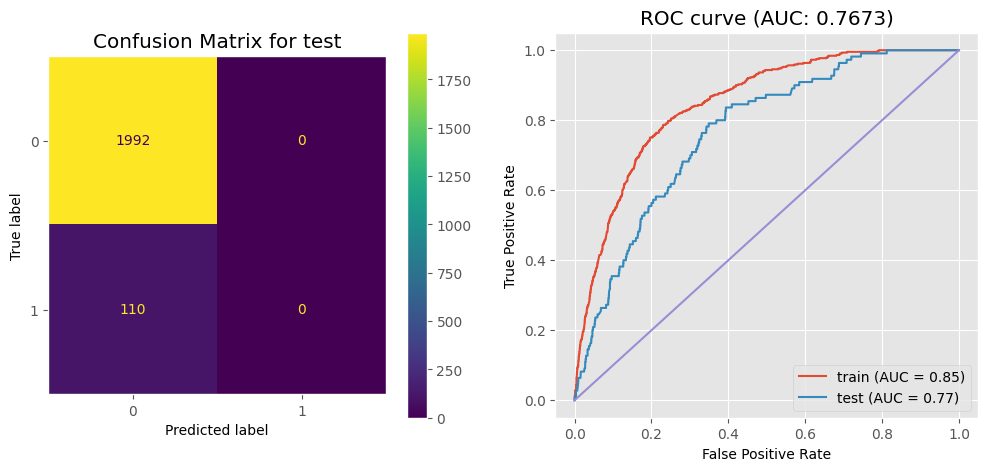

In [133]:
lr = LogisticRegression(max_iter=1000, C=0.01)
lr.fit(X_train, y_train)
evaluate(lr)

### 2.2. Random Forest

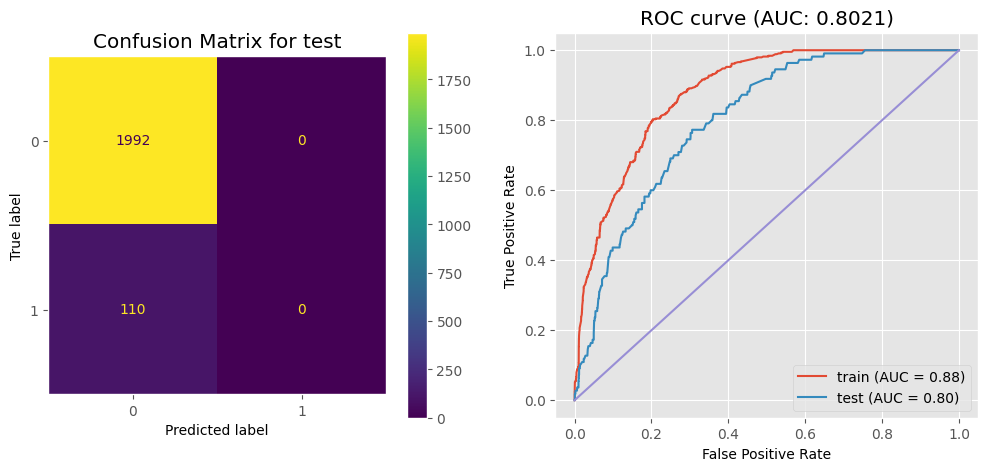

In [134]:
rf = RandomForestClassifier(max_depth=6, n_estimators=50)
rf.fit(X_train, y_train)
evaluate(rf)

### 2.3. XGBoost 

[0.54336858 0.46044473 0.63627232 0.14417607 0.51470709]


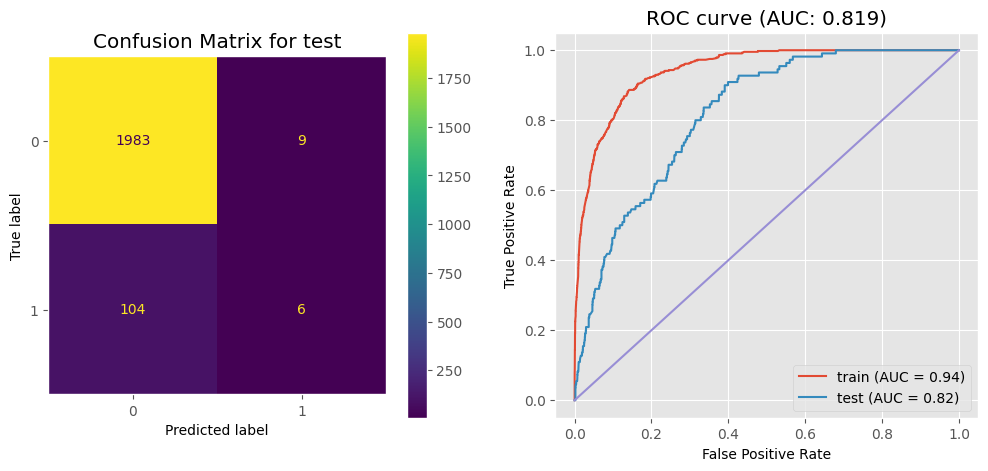

In [144]:
param_xgb = {
    'max_depth' : [3, 4, 5, 6, 8, 10],
    'n_estimators' : [50, 100, 200, 300],
    'alpha' : [0, 0.1, 1, 10]
}

# xg = GridSearchCV(XGBClassifier(), param_grid=param_xgb)
xg = XGBClassifier(max_depth=4, n_estimators=200)
print(cross_val_score(xg, X, y, cv=5, scoring='roc_auc'))
xg.fit(X_train, y_train)
evaluate(xg)

### 2.4. AdaBoost

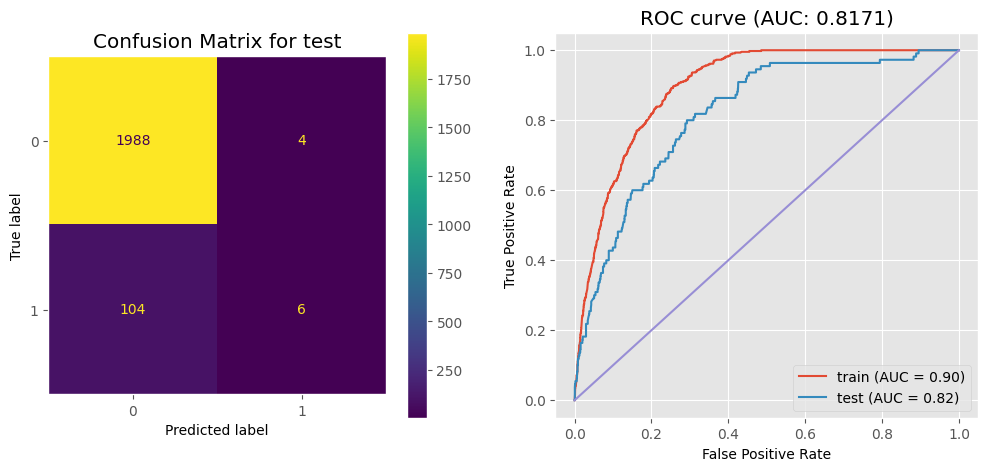

In [137]:
ada = AdaBoostClassifier(n_estimators=500)
ada.fit(X_train, y_train)
evaluate(ada)

### 2.5. SVC

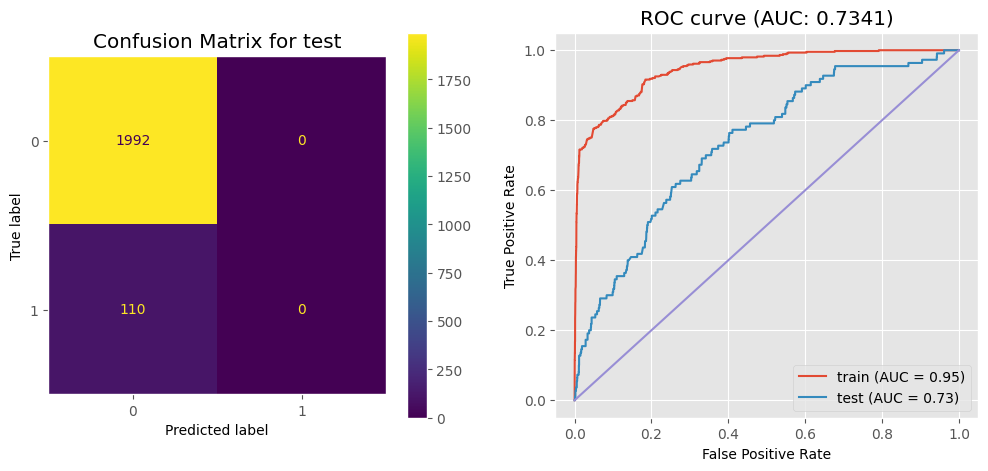

In [138]:
svc = SVC(probability=True, degree=2)
svc.fit(X_train, y_train)
evaluate(svc)

### 2.6 simpleNN

Epoch 1/5


2023-11-20 16:33:44.819110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


211/211 [==============================] - 3s 11ms/step - loss: 0.2285 - accuracy: 0.9426 - val_loss: 0.2000 - val_accuracy: 0.9488
Epoch 2/5
211/211 [==============================] - 2s 9ms/step - loss: 0.1953 - accuracy: 0.9470 - val_loss: 0.2057 - val_accuracy: 0.9488
Epoch 3/5
211/211 [==============================] - 2s 9ms/step - loss: 0.1856 - accuracy: 0.9472 - val_loss: 0.1915 - val_accuracy: 0.9488
Epoch 4/5
211/211 [==============================] - 2s 9ms/step - loss: 0.1773 - accuracy: 0.9473 - val_loss: 0.2092 - val_accuracy: 0.9488
Epoch 5/5
66/66 [==============================] - 0s 2ms/step


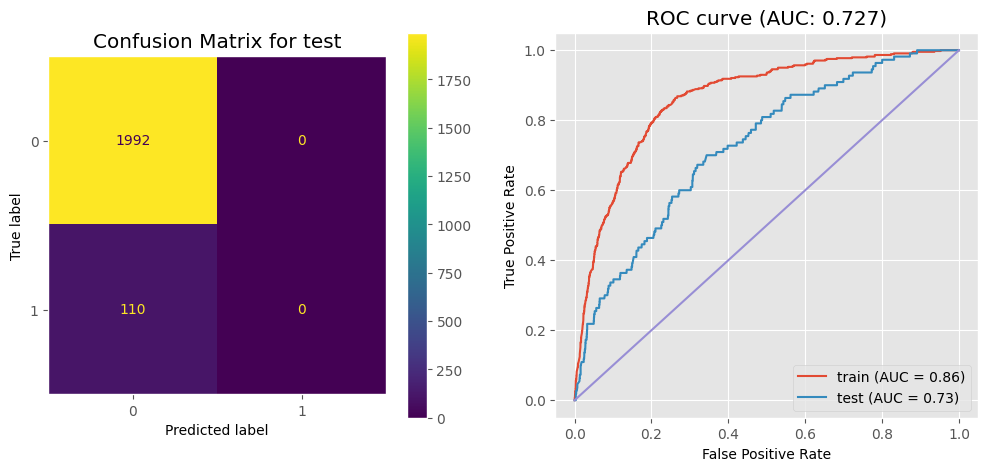

In [139]:
def create_NN(meta={}):
    ## used in scikeras wrapper
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    ## Instantiate Model with 2 hidden layers
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:])) # input layer
    model.add(Dense(128, activation='relu', name=f'Hidden1')) # 1st hidden layer
    model.add(Dropout(0.3, name=f'Dropout1')) 
    model.add(Dense(64, activation='relu', name=f'Hidden2')) # 2nd hidden layer
    model.add(Dropout(0.3, name=f'Dropout2')) 
    model.add(Dense(32, activation='relu', name=f'Hidden3')) # 2nd hidden layer
    model.add(Dropout(0.3, name=f'Dropout3')) 
    model.add(Dense(n_classes_, activation='softmax', name='Output')) # output layer
    return model

NN = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=5, metrics=['accuracy'], validation_split=0.2)
NN.fit(X_train, y_train)
evaluate(NN)

# 3. submission


In [95]:
## join tables
merged_test = test.merge(right=weather1, on=['Date','Year','Month','Year_Month'], how='left')

## create weather features
merged_test['Tmax_past3'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmax'))
merged_test['Tmax_past7'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmax'))
merged_test['Tmin_past3'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmin'))
merged_test['Tmin_past7'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmin'))
merged_test['Rain_past3'] = merged_test['Date'].apply(lambda x: get_past_rain(x, 3))

In [96]:
## dummify categorical features
## scaling
X_test = pd.concat(
    [pd.DataFrame(poly.transform(merged_test[feature_num]), columns=poly.get_feature_names_out(), index=merged_test.index),
    pd.get_dummies(merged_test[feature_cat], dtype=int)], axis=1)

X_test, _ = X_test.align(X_train, join='right', axis=1, fill_value=0)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

## re-fit
xg.fit(X, y)

## predict
prediction = ada.predict_proba(X_test)[:,1]
result_df = merged_test.copy()
result_df['WnvPresent'] = prediction

## save to file
result_df[['Id','WnvPresent']].to_csv('submission.csv', index=False)